In [176]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

In [177]:

def normalize_metrics(shd, tene, tere, original_matrix):
    """
    Normalize the SHD, TENE, and TERE scores based on matrix dimensions and edge counts.
    """

    total_elements = original_matrix.size
    true_edges_original = (original_matrix == 1).sum().sum()
    normalized_shd = shd / total_elements
    normalized_tene = tene / true_edges_original if true_edges_original > 0 else 0
    normalized_tere = tere / true_edges_original if true_edges_original > 0 else 0
    
    return normalized_shd, normalized_tene, normalized_tere


def evaluate_adjacency_matrices(original, new):
    """
    Evaluate similarity between two adjacency matrices using several metrics.
    """
    assert original.shape == new.shape, "Matrices must be of the same shape"

    # Flatten matrices
    original_flat = original.flatten()
    new_flat = new.flatten()
    
    # Structural Hamming Distance (SHD)
    shd = np.sum(original_flat != new_flat)

    # True Positives, False Positives, etc.
    tp = np.sum((original_flat == 1) & (new_flat == 1))
    fn = np.sum((original_flat == 1) & (new_flat == 0))
    fp = np.sum((original_flat == 0) & (new_flat == 1))
    tn = np.sum((original_flat == 0) & (new_flat == 0))

    # TENE: True Edge to Negative Edge
    tene = fn

    f1 = f1_score(original_flat, new_flat)
    # 2. True Edge to Negative Edge (TENE)
    true_edges_original = original == 1
    missing_edges = (true_edges_original & (new == 0)).sum()
    
    # 3. True Edge to Reverse Edge (TERE)

    true_edges = np.argwhere(original == 1)
    reverse_edges = 0

    for (i, j) in true_edges:
        if new[j, i] == 1:  # Check reverse edge
            reverse_edges += 1
            print(f"!!!!!!!!!!!!!Reverse edge found between {i} and {j}")

    normalized_shd, normalized_tene, normalized_tere = normalize_metrics(shd, missing_edges, reverse_edges, original)

    return {
        "SHD":          round(shd,4),
        "SHD (normalized)": round(normalized_shd,4),
        "TENE":         round(missing_edges,4),
        "TENE (normalized)": round(normalized_tene,4),
        "TERE":         round(reverse_edges,4),
        "TERE (normalized)": round(normalized_tere,4),
        "F1 Score":     round(f1,4), 
    }

In [181]:
def mediator_removal(A): #A = adj_matrix.copy().to_numpy()
    """
    Remove direct edges that can be mediated by other nodes.
    """
    n = len(A)
    A_new = [row[:] for row in A]

    for i in range(n):
        for j in range(n):
            # Check if there is a direct edge from i to j
            if i != j and A[i][j] == 1:
                # Check if there exists a mediator k such that i -> k and k -> j
                has_indirect_path = any(
                    A[i][k] == 1 and A[k][j] == 1
                    for k in range(n) if k != i and k != j
                )
                # If an indirect path exists through some k, remove the direct edge
                if has_indirect_path:
                    A_new[i][j] = 0

    return np.array(A_new)

def remove_true_bidirectional_conflicts(df: pd.DataFrame):
    df_filtered = df.copy()
    
    # Filter only TRUE relationships
    true_df = df[df['answer'] == True]

    to_remove = []

    for i, row in true_df.iterrows():
        var1, var2 = row['var1'], row['var2']
        prob1 = row['probability']

        reverse_match = true_df[
            (true_df['var1'] == var2) & 
            (true_df['var2'] == var1)
        ]
        
        if not reverse_match.empty:
            prob2 = reverse_match.iloc[0]['probability']

            if prob1 < prob2:
                to_remove.append(i)
            else:
                to_remove.append(reverse_match.index[0])

    # Remove marked rows
    df_filtered = df_filtered.drop(index=to_remove).reset_index(drop=True)
    return df_filtered

In [182]:
def create_adjacency_matrix(df, node_order):
    adj_matrix = pd.DataFrame(0, index=node_order, columns=node_order)
    
    for _, row in df.iterrows():
        if row['answer']:  # only add TRUE relationships
            source = row['var1']
            target = row['var2']
            if source in node_order and target in node_order:
                adj_matrix.loc[source, target] = 1

    return adj_matrix

def extract_short_version(s):
    start = s.find("'") + 1
    end = s.find("'", start)
    return s[start:end]    

In [183]:
import pyAgrum as gum
import pandas as pd
import pyAgrum.lib.notebook as gnb

def create_bayesnet_from_adjacency(df):
    """
    Creates a Bayesian network in pyAgrum from a pandas DataFrame adjacency matrix.

    Parameters:
    - df (pd.DataFrame): A square DataFrame where rows and columns are node names,
                         and values are 0 (no edge) or 1 (edge).

    Returns:
    - bn (gum.BayesNet): The created Bayesian network with structure defined.
    """
    # Create an empty Bayesian network
    bn = gum.BayesNet("MedicalDiagnosisNetwork")
    
    # Add nodes (variables) to the network
    node_ids = {}
    for node in df.index:
        # Assume binary states (true/false) for all nodes
        var = gum.LabelizedVariable(node, node, 2)
        node_id = bn.add(var)
        node_ids[node] = node_id
    
    # Add arcs based on the adjacency matrix
    for i, row in df.iterrows():
        for j, value in row.items():
            if value == 1:
                parent_id = node_ids[i]
                medicine_id = node_ids[j]
                bn.addArc(parent_id, medicine_id)
    
    return bn

In [ ]:
adj_matrix_origin = pd.read_csv("data/adj_matrix_med.csv", index_col=0)
var_unique = list(adj_matrix_origin.columns.unique())
adj_matrix_origin


,Eat Fatty Food,Arteriosclerosis,Right Heart Syndrome,Left Heart Syndrome,Lungs Sound Funny,Difficulty Breathing,Smoking,Radon Exposure,Lung Cancer,Cough Up Blood
Eat Fatty Food,0,1,0,0,0,0,0,0,0,0
Arteriosclerosis,0,0,1,1,0,0,0,0,0,0
Right Heart Syndrome,0,0,0,0,0,0,0,0,0,0
Left Heart Syndrome,0,0,0,0,1,1,0,0,0,0
Lungs Sound Funny,0,0,0,0,0,0,0,0,0,0
Difficulty Breathing,0,0,0,0,0,0,0,0,0,0
Smoking,0,0,0,0,0,0,0,0,1,0
Radon Exposure,0,0,0,0,0,0,0,0,1,0
Lung Cancer,0,0,0,0,0,1,0,0,0,1
Cough Up Blood,0,0,0,0,0,0,0,0,0,0


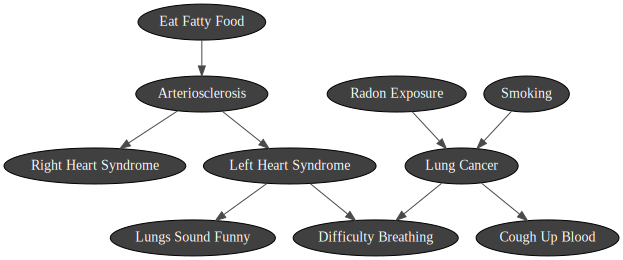

In [186]:
bn = create_bayesnet_from_adjacency(adj_matrix_origin)
gnb.showBN(bn, size = "10")

In [187]:
import os
import glob
import pandas as pd

def clean_dataframe(df):
    df["answer_binary"] = df["answer"].astype(bool).astype(int)
    df = df[~df["verb"].str.contains("NOT", na=False)].reset_index(drop=True)
    df["var1"] = df["var1"].apply(extract_short_version).str.replace(" ", "_")
    df["var2"] = df["var2"].apply(extract_short_version).str.replace(" ", "_")
    return df

def evaluate_and_store(adj_matrix, label_type, verb, var_unique, origin_matrix, store_dict, index_list, results_df):
    result = evaluate_adjacency_matrices(origin_matrix.to_numpy(), adj_matrix.to_numpy())
    result["verb"] = verb
    result["type"] = label_type
    index = f"{label_type}_{verb}".replace(" ", "_")
    
    index_list.append(index)
    store_dict[index] = adj_matrix.copy()
    
    result_row = pd.DataFrame([result], columns=results_df.columns)
    return pd.concat([results_df, result_row], ignore_index=True)

# Initialize
df_results = pd.DataFrame(columns=["verb", "type", "SHD", "SHD (normalized)", "TENE", "TENE (normalized)", "TERE", "TERE (normalized)", "F1 Score"])
df_all_adj_matrices_save = {}
index_all = []

path = "results/medicine/"
files = glob.glob(os.path.join(path, "*.csv"))

for file in files:
    print(file)
    df = pd.read_csv(file)
    df = clean_dataframe(df)

    var_unique = df["var1"].unique()
    verb = df["verb"].iloc[0]

    # Original
    adj_matrix = create_adjacency_matrix(df, var_unique)
    df_results = evaluate_and_store(adj_matrix, "llm", verb, var_unique, adj_matrix_origin, df_all_adj_matrices_save, index_all, df_results)

    # Cycle Removal
    df_no_cycles = remove_true_bidirectional_conflicts(df)
    adj_matrix_no_cycles = create_adjacency_matrix(df_no_cycles, var_unique)
    df_results = evaluate_and_store(adj_matrix_no_cycles, "cycle", verb, var_unique, adj_matrix_origin, df_all_adj_matrices_save, index_all, df_results)

    # Mediator Removal
    adj_wo_mediator = mediator_removal(adj_matrix_no_cycles.to_numpy())
    adj_matrix_no_mediators = pd.DataFrame(adj_wo_mediator, index=var_unique, columns=var_unique)
    df_results = evaluate_and_store(adj_matrix_no_mediators, "mediator", verb, var_unique, adj_matrix_origin, df_all_adj_matrices_save, index_all, df_results)


results/medicine\causal_relationships_affect.csv
results/medicine\causal_relationships_cause.csv
results/medicine\causal_relationships_increase the chance of.csv
results/medicine\causal_relationships_influence.csv
results/medicine\causal_relationships_lead to.csv
results/medicine\causal_relationships_raise the risk of.csv
results/medicine\causal_relationships_result in.csv


In [188]:
# df_results.to_csv("results/medicine/adj_metrx/df_results.csv", index=False)

df_results[df_results['type'] == "llm"]

,verb,type,SHD,SHD (normalized),TENE,TENE (normalized),TERE,TERE (normalized),F1 Score
0,affect,llm,16,0.16,0,0.0,0,0.0,0.5294
3,cause,llm,16,0.16,0,0.0,0,0.0,0.5294
6,increase the chance of,llm,17,0.17,0,0.0,0,0.0,0.5143
9,influence,llm,17,0.17,0,0.0,0,0.0,0.5143
12,lead to,llm,17,0.17,0,0.0,0,0.0,0.5143
15,raise the risk of,llm,16,0.16,0,0.0,0,0.0,0.5294
18,result in,llm,17,0.17,0,0.0,0,0.0,0.5143


In [189]:
df_results[df_results['type'] == "cycle"]

,verb,type,SHD,SHD (normalized),TENE,TENE (normalized),TERE,TERE (normalized),F1 Score
1,affect,cycle,15,0.15,0,0.0,0,0.0,0.5455
4,cause,cycle,16,0.16,0,0.0,0,0.0,0.5294
7,increase the chance of,cycle,16,0.16,0,0.0,0,0.0,0.5294
10,influence,cycle,17,0.17,0,0.0,0,0.0,0.5143
13,lead to,cycle,16,0.16,0,0.0,0,0.0,0.5294
16,raise the risk of,cycle,16,0.16,0,0.0,0,0.0,0.5294
19,result in,cycle,17,0.17,0,0.0,0,0.0,0.5143


In [190]:
df_results[df_results['type'] == "mediator"]

,verb,type,SHD,SHD (normalized),TENE,TENE (normalized),TERE,TERE (normalized),F1 Score
2,affect,mediator,8,0.08,2,0.2222,0,0.0,0.6364
5,cause,mediator,8,0.08,3,0.3333,0,0.0,0.6000
8,increase the chance of,mediator,8,0.08,3,0.3333,0,0.0,0.6000
11,influence,mediator,10,0.10,4,0.4444,0,0.0,0.5000
14,lead to,mediator,8,0.08,2,0.2222,0,0.0,0.6364
17,raise the risk of,mediator,6,0.06,1,0.1111,0,0.0,0.7273
20,result in,mediator,10,0.10,4,0.4444,0,0.0,0.5000


In [ ]:
# import pickle
# with open("results/medicine/adj_metrx/df_all_adj_matrices_save.pkl", "wb") as f:
#     pickle.dump(df_all_adj_matrices_save, f)
# # # load dic df_all_adj_matrices_save
# # with open("results/medicine/adj_metrx/df_all_adj_matrices_save.pkl", "rb") as f:
# #     df_all_adj_matrices_save_1 = pickle.load(f)


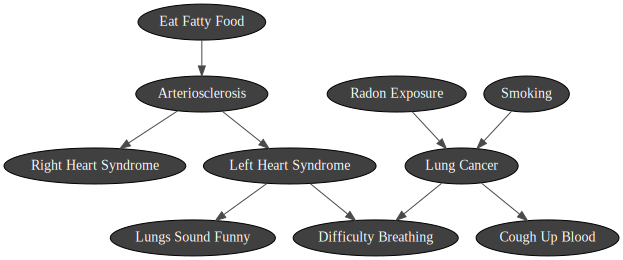

In [196]:
bn = create_bayesnet_from_adjacency(adj_matrix_origin)
gnb.showBN(bn, size = "10")

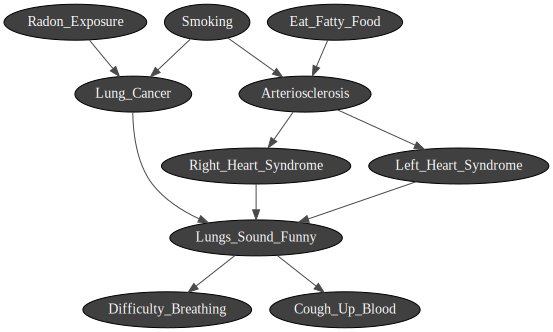

In [197]:
bn = create_bayesnet_from_adjacency(df_all_adj_matrices_save['mediator_increase_the_chance_of'])
gnb.showBN(bn, size = "10")

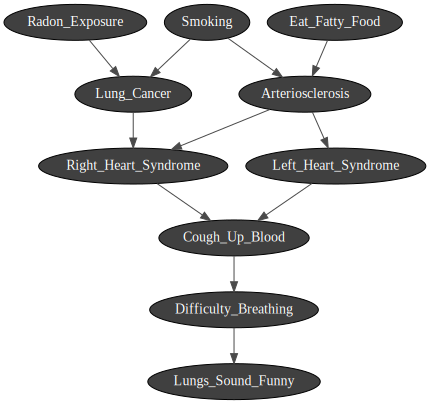

In [198]:
bn = create_bayesnet_from_adjacency(df_all_adj_matrices_save['mediator_result_in'])
gnb.showBN(bn, size = "10")

In [200]:
import pandas as pd
import glob
import os
from collections import Counter

# Collect all rows from all files into a single DataFrame
path = "results/medicine/"
all_files = glob.glob(os.path.join(path, "*.csv"))

df_all = pd.DataFrame()

for file in all_files:
    df = pd.read_csv(file)
    df = df[["var1", "var2", "verb", "answer"]]
    df_all = pd.concat([df_all, df], ignore_index=True)
df_all = df_all[~df_all["verb"].str.contains("NOT", na=False)].reset_index(drop=True)
df_all = clean_dataframe(df_all)

# Group by (var1, var2, verb) and get the most common answer
def majority_vote(answers):
    count = Counter(answers)
    return count.most_common(1)[0][0]

df_grouped = df_all.groupby(["var1", "var2"])["answer"].agg(majority_vote).reset_index()
# df_grouped["ration_true_false"] = df_all.groupby(["var1", "var2"])["answer"].agg(lambda x: (x == True).sum() / len(x))
count = df_all.groupby(["var1", "var2"])["answer"].agg(lambda x: (x == True).sum() / len(x)).reset_index(name="ratio_true_false")

# Merge the ratio into df_grouped
df_grouped = pd.merge(df_grouped, count, on=["var1", "var2"])

# This is your desired output
df_average = df_grouped

print(df_average.head())



               var1                  var2  answer  ratio_true_false
0  Arteriosclerosis        Cough_Up_Blood   False               0.0
1  Arteriosclerosis  Difficulty_Breathing    True               1.0
2  Arteriosclerosis        Eat_Fatty_Food   False               0.0
3  Arteriosclerosis   Left_Heart_Syndrome    True               1.0
4  Arteriosclerosis           Lung_Cancer   False               0.0


In [ ]:
# df_grouped.to_csv("results/medicine/adj_metrx/df_grouped.csv", index=False)

In [202]:
adj_matrix = create_adjacency_matrix(df_average, var_unique)

In [203]:
verb = "avg"

# Original
adj_matrix = create_adjacency_matrix(df_average, var_unique)
df_results = evaluate_and_store(adj_matrix, "llm", verb, var_unique, adj_matrix_origin, df_all_adj_matrices_save, index_all, df_results)

# Mediator Removal
adj_wo_mediator = mediator_removal(adj_matrix.to_numpy())
adj_matrix_no_mediators = pd.DataFrame(adj_wo_mediator, index=var_unique, columns=var_unique)
df_results = evaluate_and_store(adj_matrix_no_mediators, "mediator", verb, var_unique, adj_matrix_origin, df_all_adj_matrices_save, index_all, df_results)

In [204]:
df_results

,verb,type,SHD,SHD (normalized),TENE,TENE (normalized),TERE,TERE (normalized),F1 Score
0,affect,llm,16,0.16,0,0.0000,0,0.0,0.5294
1,affect,cycle,15,0.15,0,0.0000,0,0.0,0.5455
2,affect,mediator,8,0.08,2,0.2222,0,0.0,0.6364
3,cause,llm,16,0.16,0,0.0000,0,0.0,0.5294
4,cause,cycle,16,0.16,0,0.0000,0,0.0,0.5294
5,cause,mediator,8,0.08,3,0.3333,0,0.0,0.6000
6,increase the chance of,llm,17,0.17,0,0.0000,0,0.0,0.5143
7,increase the chance of,cycle,16,0.16,0,0.0000,0,0.0,0.5294
8,increase the chance of,mediator,8,0.08,3,0.3333,0,0.0,0.6000
9,influence,llm,17,0.17,0,0.0000,0,0.0,0.5143


In [ ]:
# df_results.to_csv("results/results_medicine.csv", index=False)

In [206]:
adj_matrix_no_mediators

,Eat_Fatty_Food,Arteriosclerosis,Right_Heart_Syndrome,Left_Heart_Syndrome,Lungs_Sound_Funny,Difficulty_Breathing,Smoking,Radon_Exposure,Lung_Cancer,Cough_Up_Blood
Eat_Fatty_Food,0,1,0,0,0,0,0,0,0,0
Arteriosclerosis,0,0,1,1,0,0,0,0,0,0
Right_Heart_Syndrome,0,0,0,0,0,1,0,0,0,1
Left_Heart_Syndrome,0,0,0,0,0,1,0,0,0,1
Lungs_Sound_Funny,0,0,0,0,0,0,0,0,0,0
Difficulty_Breathing,0,0,0,0,1,0,0,0,0,0
Smoking,0,1,0,0,0,0,0,0,1,0
Radon_Exposure,0,0,0,0,0,0,0,0,1,0
Lung_Cancer,0,0,0,0,0,1,0,0,0,1
Cough_Up_Blood,0,0,0,0,0,0,0,0,0,0


In [207]:
for i in df_all_adj_matrices_save:
    print (i)

llm_affect
cycle_affect
mediator_affect
llm_cause
cycle_cause
mediator_cause
llm_increase_the_chance_of
cycle_increase_the_chance_of
mediator_increase_the_chance_of
llm_influence
cycle_influence
mediator_influence
llm_lead_to
cycle_lead_to
mediator_lead_to
llm_raise_the_risk_of
cycle_raise_the_risk_of
mediator_raise_the_risk_of
llm_result_in
cycle_result_in
mediator_result_in
llm_avg
mediator_avg


In [208]:
def create_bayesnet_from_adjacency(df):
    """
    Creates a Bayesian network in pyAgrum from a pandas DataFrame adjacency matrix.

    Parameters:
    - df (pd.DataFrame): A square DataFrame where rows and columns are node names,
                         and values are 0 (no edge) or 1 (edge).

    Returns:
    - bn (gum.BayesNet): The created Bayesian network with structure defined.
    """
    # Create an empty Bayesian network
    bn = gum.BayesNet("MedicalDiagnosisNetwork")
    
    # Add nodes (variables) to the network
    node_ids = {}
    for node in df.index:
        # Assume binary states (true/false) for all nodes
        var = gum.LabelizedVariable(node, node, 2)
        node_id = bn.add(var)
        node_ids[node] = node_id
    
    # Add arcs based on the adjacency matrix
    for i, row in df.iterrows():
        for j, value in row.items():
            if value == 1:
                parent_id = node_ids[i]
                child_id = node_ids[j]
                # print(f"Adding arc from {i} to {j}")
                try:
                    bn.addArc(parent_id, child_id)
                except gum.InvalidDirectedCycle:
                    print(f"Cycle detected: Cannot add arc from {i} to {j}. Skipping.")
    
    return bn

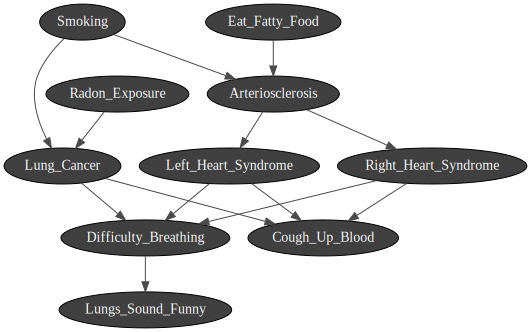

In [209]:
bn = create_bayesnet_from_adjacency(df_all_adj_matrices_save['mediator_avg'])
gnb.showBN(bn, size = "10")

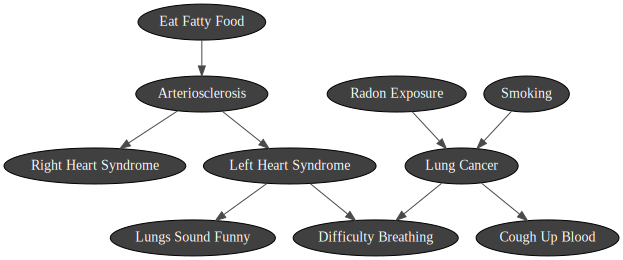

In [210]:
bn = create_bayesnet_from_adjacency(adj_matrix_origin)
gnb.showBN(bn, size = "10")